# Nov 21, 2023: state space models

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = False

In [2]:
# create an HMM
time_bins = 200
num_states = 5
obs_dim = 2

true_hmm = ssm.HMM(K=num_states, D=obs_dim, transitions='recurrent', observations='robust_autoregressive')

thetas = np.linspace(0, 2 * np.pi, num_states, endpoint=False)
true_hmm.observations.mus = 3 * np.column_stack((np.cos(thetas),np.sin(thetas)))

In [3]:
# sample from HMM
true_states, obs = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(obs)

In [4]:
# plot observations
lim = 0.85 * abs(obs).max()
XX, YY = np.meshgrid(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100))
data = np.column_stack((XX.ravel(), YY.ravel()))
input = np.zeros((data.shape[0], 0))
mask = np.ones_like(data, dtype=bool)
tag = None
lls = true_hmm.observations.log_likelihoods(data, input, mask, tag)

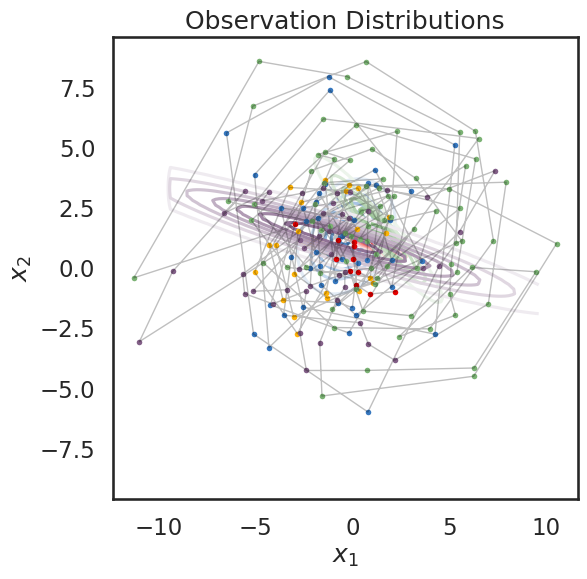

In [5]:
plt.figure(figsize=(6, 6))
for k in range(num_states):
    plt.contour(XX, YY, np.exp(lls[:, k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    plt.plot(obs[true_states==k, 0], obs[true_states==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(obs[:, 0], obs[:, 1], '-k', lw=1, alpha=0.25)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Observation Distributions")

if save_figures:
    plt.savefig("hmm_1.pdf")

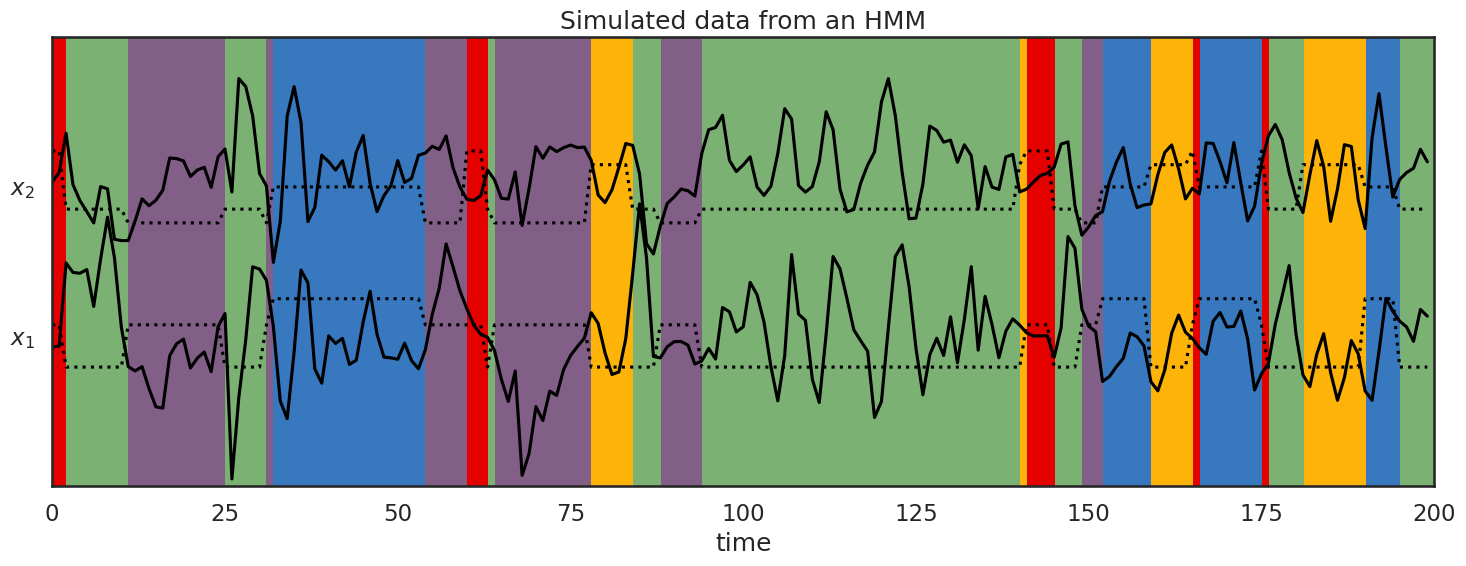

In [6]:
lim = 1.05 * abs(obs).max()
plt.figure(figsize=(15, 6))
plt.imshow(
    true_states[None, :], 
    aspect='auto',
    cmap=cmap,
    vmin=0, 
    vmax=len(colors)-1,
    extent=(0, time_bins, -lim, (obs_dim)*lim)
)

Ey = true_hmm.observations.mus[true_states]
for d in range(obs_dim):
    plt.plot(obs[:, d] + lim * d, '-k')
    plt.plot(Ey[:, d] + lim * d, ':k')

plt.xlim(0, time_bins)
plt.xlabel("time")
plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

plt.title("Simulated data from an HMM")

plt.tight_layout()

if save_figures:
    plt.savefig("hmm_2.pdf")

/home/govindas/miniconda3/envs/nw_estim/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/50 [00:00<?, ?it/s]

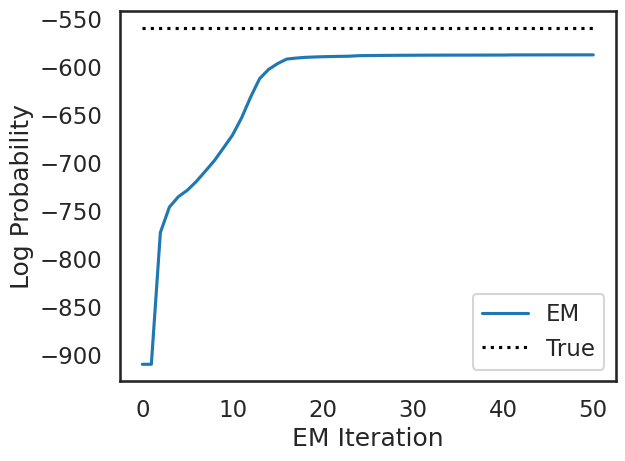

In [7]:
# fit an HMM to synthetic data
data = obs
N_iters = 50

hmm = ssm.HMM(K=num_states, D=obs_dim, transitions='recurrent', observations='robust_autoregressive')
hmm_lls = hmm.fit(obs, method='em', num_iters=N_iters, init_method='kmeans')

plt.plot(hmm_lls, label='EM')
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label='True')
plt.xlabel('EM Iteration')
plt.ylabel('Log Probability')
plt.legend(loc='lower right')
plt.show()

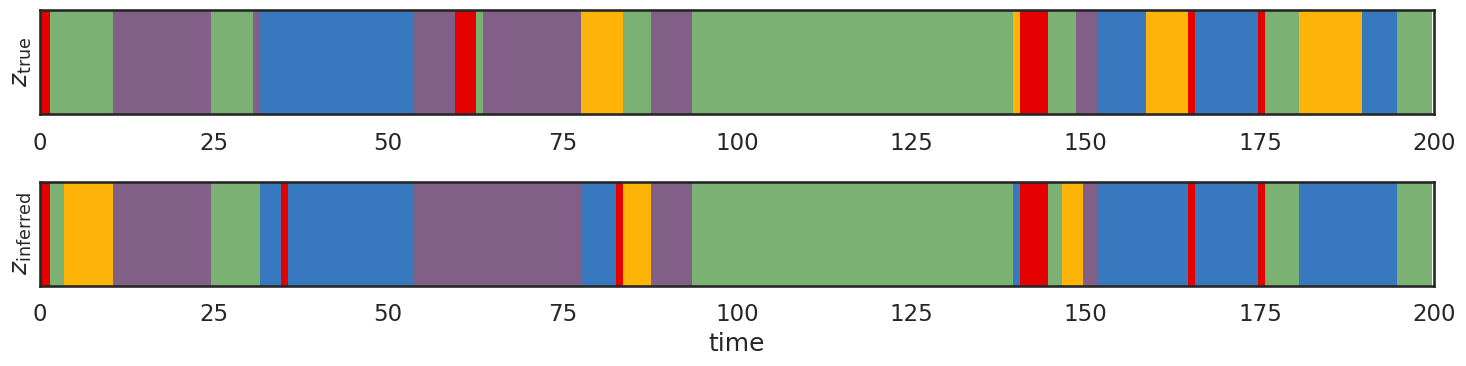

In [8]:
most_likely_states = hmm.most_likely_states(obs)
hmm.permute(find_permutation(true_states, most_likely_states))

hmm_z = hmm.most_likely_states(data)

plt.figure(figsize=(15, 4))
plt.subplot(211)
plt.imshow(true_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

Text(0.5, 0, 'time')

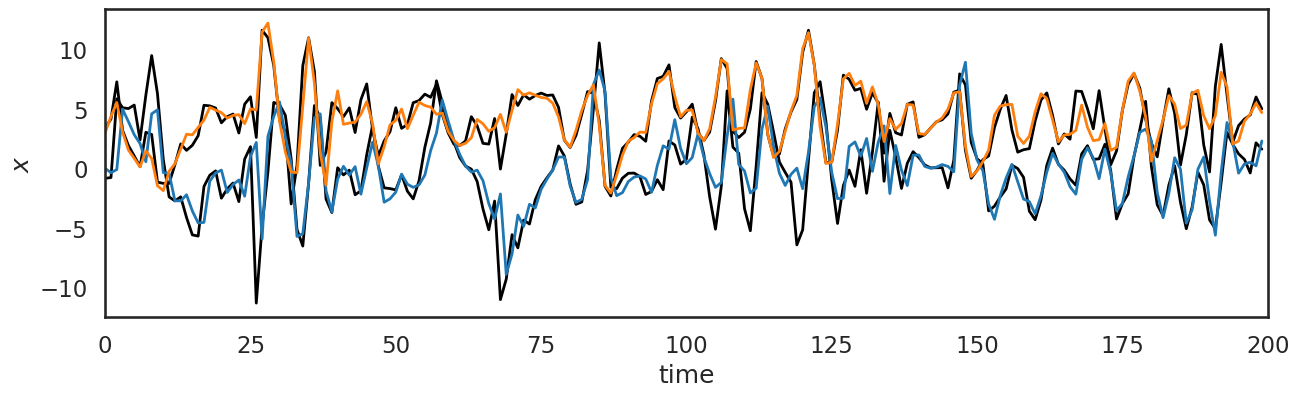

In [9]:
# smoothing the data
hmm_x = hmm.smooth(obs)

plt.figure(figsize=(15, 4))
plt.plot(obs + 3 * np.arange(obs_dim), '-k', lw=2)
plt.plot(hmm_x + 3 * np.arange(obs_dim), '-', lw=2)
plt.xlim(0, time_bins)
plt.ylabel("$x$")
# plt.yticks([])
plt.xlabel("time")

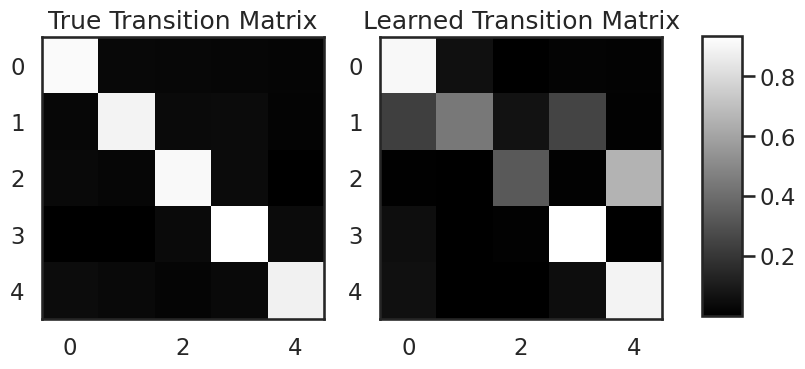

In [10]:
true_transition_mat = true_hmm.transitions.transition_matrix
learned_transition_mat = hmm.transitions.transition_matrix

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

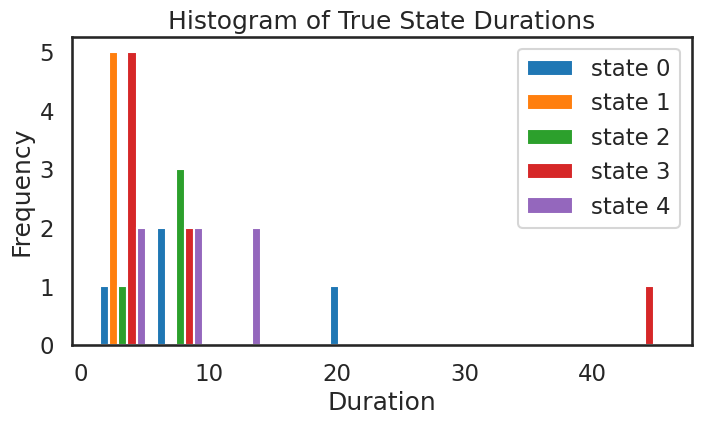

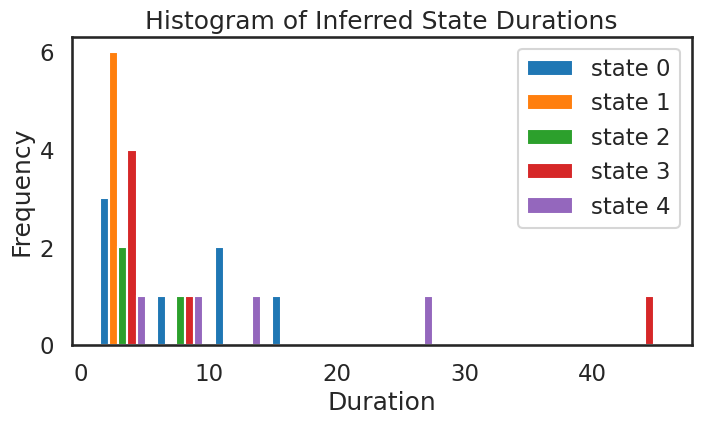

In [11]:
true_state_list, true_durations = ssm.util.rle(true_states)
inferred_state_list, inferred_durations = ssm.util.rle(hmm_z)

# Rearrange the lists of durations to be a nested list where
# the nth inner list is a list of durations for state n
true_durs_stacked = []
inf_durs_stacked = []
for s in range(num_states):
    true_durs_stacked.append(true_durations[true_state_list == s])
    inf_durs_stacked.append(inferred_durations[inferred_state_list == s])
    
fig = plt.figure(figsize=(8, 4))
plt.hist(true_durs_stacked, label=['state ' + str(s) for s in range(num_states)])
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of True State Durations')

fig = plt.figure(figsize=(8, 4))
plt.hist(inf_durs_stacked, label=['state ' + str(s) for s in range(num_states)])
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Inferred State Durations')

plt.show()